In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras_pyramid_pooling_module import PyramidPoolingModule

In [2]:
np.random.seed(222)
tf.random.set_seed(222)

In [3]:
def plot_image_grid(data, figsize=(15, 15), cmap=None, cbar=True):
    """
    Plot the data as a grid of images.

    Args:
        data: the tensor of image data to plot in
        (M, N, H, W, C) format where M is the 
        height of the image grid, N is the width
        of the image grid, H is the height of the
        image, W is the width of the image, and C
        is the channel dimensionality of the image
        cmap: the color map to use for the data
        cbar: whether to include a color bar legend

    Returns:
        None

    """
    M, N = data.shape[0], data.shape[1]
    fig, ax = plt.subplots(nrows=M, ncols=N, sharex=True, sharey=True, figsize=figsize)
    for i in range(M):    
        for j in range(N): 
            idx = i + 1 + N * j
            im = ax[i, j].imshow(data[i, j], cmap=cmap)
            ax[i, j].axes.xaxis.set_major_locator(plt.NullLocator())
            ax[i, j].axes.yaxis.set_major_locator(plt.NullLocator())
    if cbar:
        cb_ax = fig.add_axes([1., 0.2, 0.02, 0.6])
        cbar = fig.colorbar(im, cax=cb_ax)

# Dataset

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# normalize images into [0, 1]
X_train = X_train[..., None] / 255.0
X_test = X_test[..., None] / 255.0
# get the target size of the images and number of classes
TARGET_SIZE = X_train.shape[1:]
NUM_CLASSES = np.max(y_train) + 1
# convert discrete labels to one-hot vectors
y_train = np.eye(NUM_CLASSES)[y_train.flatten()]
y_test = np.eye(NUM_CLASSES)[y_test.flatten()]

In [5]:
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 10))

In [6]:
X_test.shape, y_test.shape

((10000, 28, 28, 1), (10000, 10))

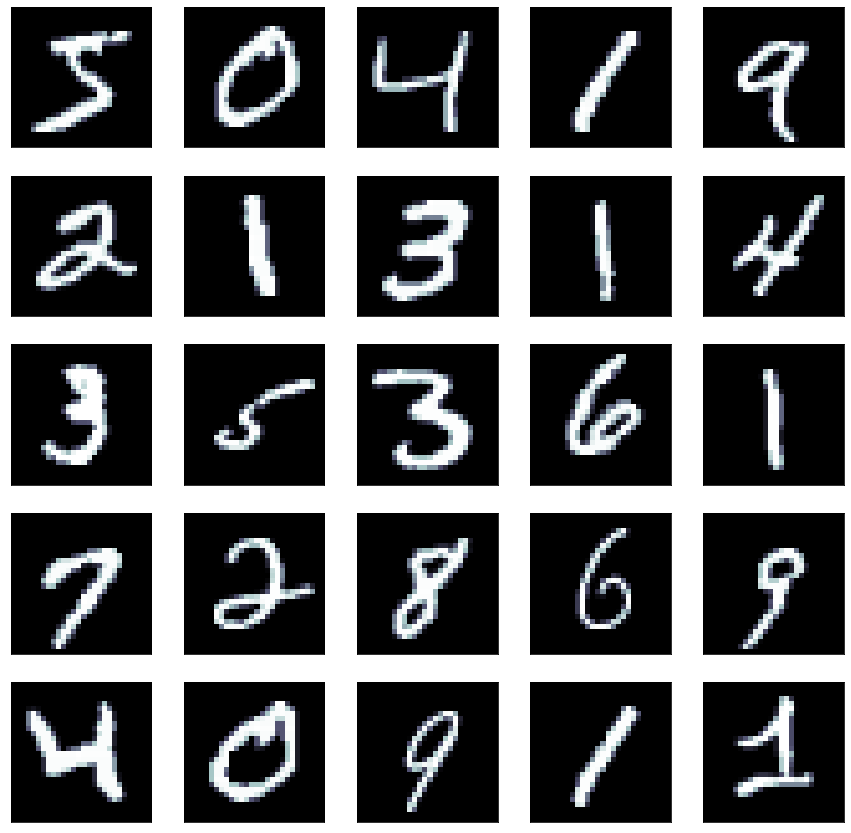

In [7]:
plot_image_grid(X_train[:25].reshape(5, 5, 28, 28, 1), cbar=False, cmap='bone')

# Model

## Baseline

In [8]:
input_layer = Input(TARGET_SIZE)
x = input_layer
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0     

In [9]:
history1 = model.fit(X_train, y_train, 
    epochs=5, 
    batch_size=10, 
    validation_split=0.3,
    shuffle=True,
)

Epoch 1/5
4200/4200 [==============================] - 239s 57ms/step - loss: 1.0590 - accuracy: 0.8894 - val_loss: 0.5077 - val_accuracy: 0.9617
Epoch 2/5
4200/4200 [==============================] - 232s 55ms/step - loss: 0.3550 - accuracy: 0.9672 - val_loss: 0.4463 - val_accuracy: 0.9574
Epoch 3/5
4200/4200 [==============================] - 230s 55ms/step - loss: 0.1811 - accuracy: 0.9775 - val_loss: 0.2615 - val_accuracy: 0.9725
Epoch 4/5
4200/4200 [==============================] - 221s 53ms/step - loss: 0.1270 - accuracy: 0.9805 - val_loss: 0.1785 - val_accuracy: 0.9777
Epoch 5/5
4200/4200 [==============================] - 221s 53ms/step - loss: 0.0792 - accuracy: 0.9861 - val_loss: 0.1748 - val_accuracy: 0.9776


In [10]:
df1 = pd.DataFrame(history1.history)
df1

,loss,accuracy,val_loss,val_accuracy
0,0.762028,0.933429,0.507727,0.961667
1,0.337193,0.968548,0.446303,0.957389
2,0.195483,0.976619,0.261507,0.972500
3,0.125899,0.981143,0.178452,0.977722
4,0.080672,0.986000,0.174824,0.977611


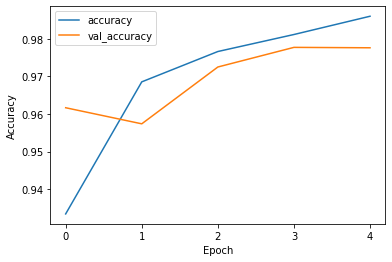

In [11]:
ax = df1[[c for c in df1.columns if 'accuracy' in c]].plot()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

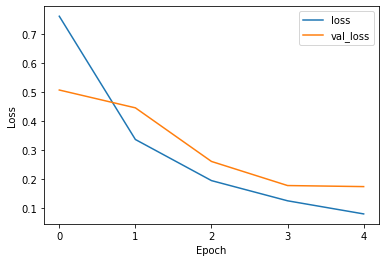

In [12]:
ax = df1[[c for c in df1.columns if 'loss' in c]].plot()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [13]:
loss1, accuracy1 = model.evaluate(X_test, y_test)

313/313 [==============================] - 7s 23ms/step - loss: 0.1267 - accuracy: 0.9789


## Pyramid Pooling Near Output

In [14]:
input_layer = Input(TARGET_SIZE)
x = input_layer
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = PyramidPoolingModule(1, (3, 3), padding='same')(x)
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 64)        0   

In [15]:
history2 = model.fit(X_train, y_train, 
    epochs=5, 
    batch_size=10, 
    validation_split=0.3,
    shuffle=True,
)

Epoch 1/5
4200/4200 [==============================] - 823s 196ms/step - loss: 1.1617 - accuracy: 0.8890 - val_loss: 0.6043 - val_accuracy: 0.9582
Epoch 2/5
4200/4200 [==============================] - 694s 165ms/step - loss: 0.3893 - accuracy: 0.9679 - val_loss: 0.3177 - val_accuracy: 0.9736
Epoch 3/5
4200/4200 [==============================] - 692s 165ms/step - loss: 0.1869 - accuracy: 0.9786 - val_loss: 0.4123 - val_accuracy: 0.9622
Epoch 4/5
4200/4200 [==============================] - 775s 185ms/step - loss: 0.1430 - accuracy: 0.9811 - val_loss: 0.2077 - val_accuracy: 0.9784
Epoch 5/5
4200/4200 [==============================] - 745s 177ms/step - loss: 0.1059 - accuracy: 0.9851 - val_loss: 0.1881 - val_accuracy: 0.9791


In [16]:
df2 = pd.DataFrame(history2.history)
df2

,loss,accuracy,val_loss,val_accuracy
0,0.845303,0.932786,0.604283,0.958167
1,0.359144,0.969214,0.317695,0.973556
2,0.196332,0.977881,0.412330,0.962167
3,0.132914,0.982381,0.207678,0.978389
4,0.099598,0.985333,0.188124,0.979111


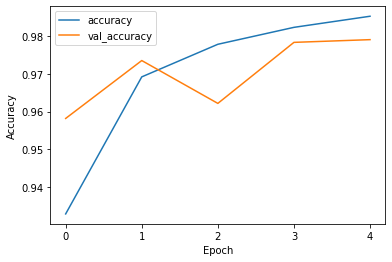

In [17]:
ax = df2[[c for c in df2.columns if 'accuracy' in c]].plot()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

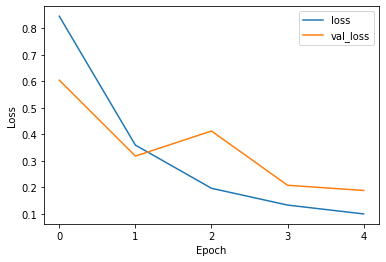

In [18]:
ax = df2[[c for c in df2.columns if 'loss' in c]].plot()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [19]:
loss2, accuracy2 = model.evaluate(X_test, y_test)

313/313 [==============================] - 42s 135ms/step - loss: 0.1461 - accuracy: 0.9828


## Pyramid Pooling Near Input

In [20]:
input_layer = Input(TARGET_SIZE)
x = input_layer
x = PyramidPoolingModule(1, (3, 3), padding='same')(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
pyramid_pooling_module_1 (Py (None, 28, 28, 5)         40        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        1344      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256 

In [21]:
history3 = model.fit(X_train, y_train, 
    epochs=5, 
    batch_size=10, 
    validation_split=0.3,
    shuffle=True,
)

Epoch 1/5
4200/4200 [==============================] - 347s 82ms/step - loss: 1.1385 - accuracy: 0.8887 - val_loss: 0.3826 - val_accuracy: 0.9672
Epoch 2/5
4200/4200 [==============================] - 350s 83ms/step - loss: 0.3313 - accuracy: 0.9688 - val_loss: 0.4859 - val_accuracy: 0.9542
Epoch 3/5
4200/4200 [==============================] - 361s 86ms/step - loss: 0.1957 - accuracy: 0.9773 - val_loss: 0.2213 - val_accuracy: 0.9713
Epoch 4/5
4200/4200 [==============================] - 361s 86ms/step - loss: 0.1182 - accuracy: 0.9813 - val_loss: 0.1526 - val_accuracy: 0.9772
Epoch 5/5
4200/4200 [==============================] - 325s 77ms/step - loss: 0.0806 - accuracy: 0.9859 - val_loss: 0.1207 - val_accuracy: 0.9804


In [22]:
df3 = pd.DataFrame(history3.history)
df3

,loss,accuracy,val_loss,val_accuracy
0,0.726905,0.935500,0.382615,0.967167
1,0.316277,0.969571,0.485867,0.954222
2,0.192380,0.977238,0.221251,0.971278
3,0.116078,0.981833,0.152626,0.977167
4,0.080879,0.985929,0.120652,0.980444


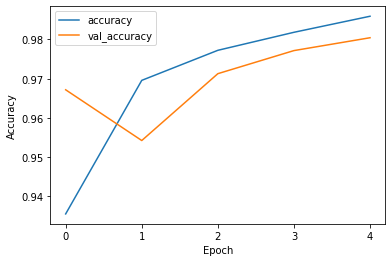

In [23]:
ax = df3[[c for c in df3.columns if 'accuracy' in c]].plot()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

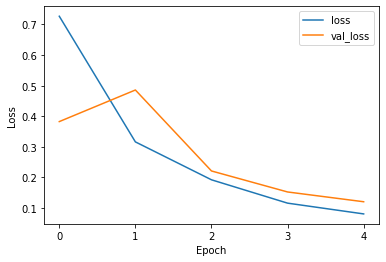

In [24]:
ax = df3[[c for c in df3.columns if 'loss' in c]].plot()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [25]:
loss3, accuracy3 = model.evaluate(X_test, y_test)

313/313 [==============================] - 23s 72ms/step - loss: 0.0793 - accuracy: 0.9868


## Comparisons

In [26]:
df = pd.DataFrame([[loss1, loss2, loss3], [accuracy1, accuracy2, accuracy3]]).T
df.columns = ['Loss', 'Accuracy']
df.index = ['Baselines', 'Pyramind Near Output', 'Pyramid Near Input']
df

,Loss,Accuracy
Baselines,0.126698,0.9789
Pyramind Near Output,0.146119,0.9828
Pyramid Near Input,0.079317,0.9868


Text(0.5, 0, 'Architecture')

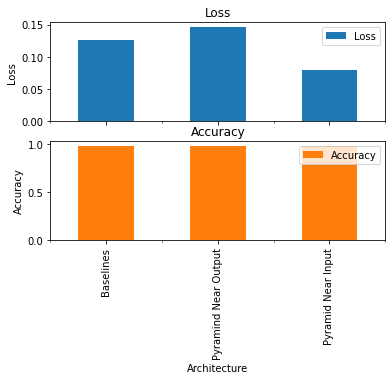

In [27]:
ax = df.plot(kind='bar', subplots=True)
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Architecture')